In [59]:
# Built-in
import os
import warnings
warnings.filterwarnings('ignore')

# Data
import numpy as np
import pandas as pd
import missingno as msno
from collections import defaultdict
import plotly.figure_factory as ff

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import time
# NLP
import nltk 
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import words, stopwords
import spacy
import re
from transformers import TFAutoModel, AutoTokenizer
import tensorflow_hub as hub
#cluster
from sklearn.cluster import AgglomerativeClustering, KMeans,MiniBatchKMeans, DBSCAN,MeanShift,SpectralClustering,Birch
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.decomposition import PCA

#metrics
from sklearn.metrics import (mean_squared_error, silhouette_samples,silhouette_score,davies_bouldin_score,
                             adjusted_rand_score,adjusted_mutual_info_score,pair_confusion_matrix)

from sklearn import cluster, manifold, metrics



from pandarallel import pandarallel

#image
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from os import listdir
import os
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

## Prétraitement des données images pour obtenir un jeu de données exploitable

In [50]:
data = pd.read_csv('data.csv')

In [51]:
path_images = 'Images/'
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


Catégorie : Baby Care


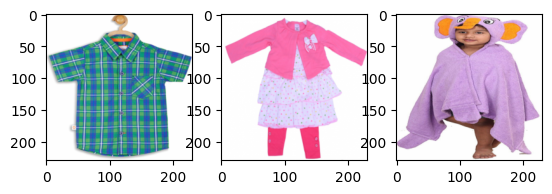

Catégorie : Beauty and Personal Care


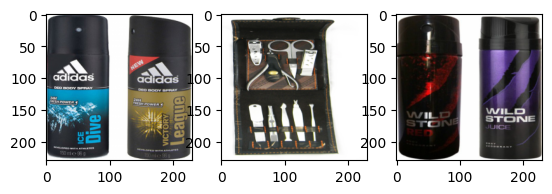

Catégorie : Computers


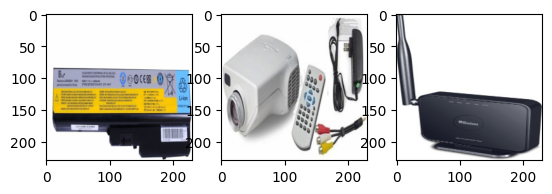

Catégorie : Home Decor & Festive Needs


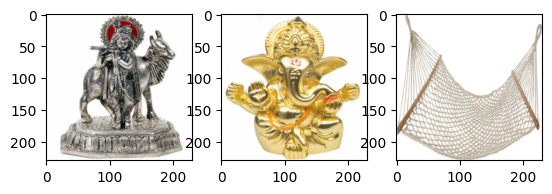

Catégorie : Home Furnishing


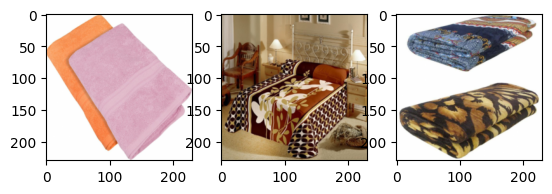

Catégorie : Kitchen & Dining


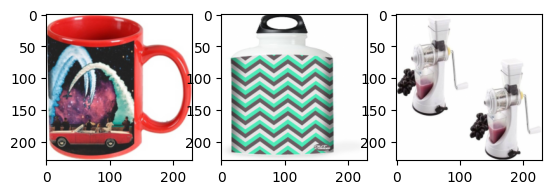

Catégorie : Watches


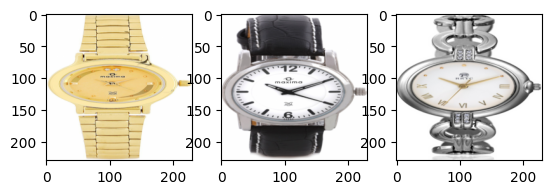

In [4]:
df_img = data.groupby('categ_1')['image']

for name, img in df_img:
    files = list(img.sample(3))
    print('Catégorie :', name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = os.path.join(path_images, files[i])
        image = imread(filename)
        image = resize(image, (230, 230)) 
        plt.imshow(image)
    plt.show()

In [5]:
def display(imglist,size):
    cols = len(imglist)
    fig = plt.figure(figsize=(size*cols,size*cols))
    for i in range(0,cols):
        a = fig.add_subplot(1, cols, i+1)
        subfig = plt.imshow(imglist[i], cmap='gray')
        #plt.get_cmap('gray')
        subfig.axes.get_xaxis().set_visible(False)
        subfig.axes.get_yaxis().set_visible(False)

On effectue et affiche plusieurs transformations sur les images : un passage en gris, l'égalisation des histogrammes et l'élimination du bruit.


## Transformation des images

In [6]:
import cv2

# Image initiale
image1 = cv2.imread(path_images+list_photos[2])

# Image convertie en gris
image2 = cv2.imread(path_images+list_photos[2],0)


# Image égalisée
image3 = cv2.equalizeHist(image2)

# Image débruitée
image4 = cv2.GaussianBlur(image3, (5, 5), 0)

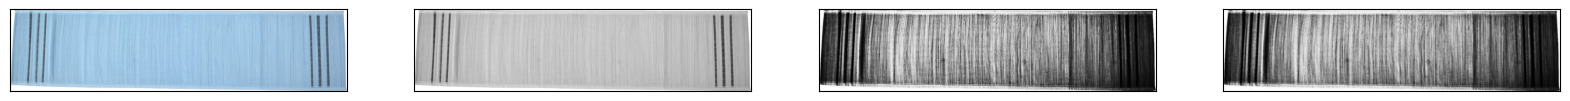

In [7]:
display([image1,image2,image3, image4],5)

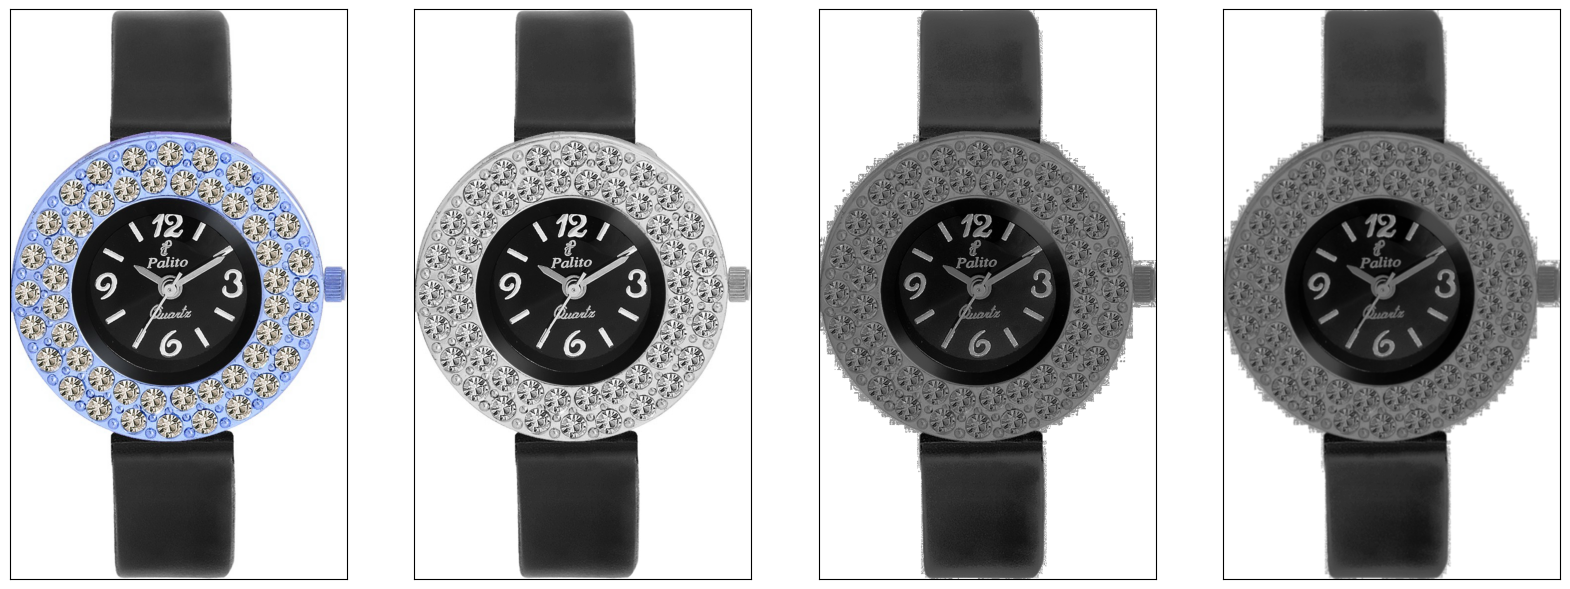

In [8]:
image1 = cv2.imread(path_images+list_photos[0])
image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image3 = cv2.equalizeHist(image2)
image4 = cv2.GaussianBlur(image3, (5, 5), 0)

display([image1,image2,image3, image4],5)

### Méthode SIFT

La méthode SIFT est un outil qui trouve des points importants dans une image. Ces points restent les mêmes même si la taille de l’image change ou si elle est tournée. C’est très utile pour comparer des images et reconnaître des objets

### Création des descripteurs de chaque image

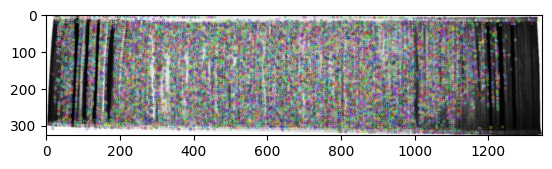

Descripteurs :  (17267, 128)



In [9]:
sift = cv2.SIFT_create()
image = cv2.imread(path_images+list_photos[2],0)
image = cv2.equalizeHist(image)
image = cv2.GaussianBlur(image, (5, 5), 0)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()

Nous avons commencé par tester avec une seule image et nous avons trouvé qu’elle contient 17267 points clés, chacun décrit par un vecteur de 128 éléments. 

Maintenant, nous allons répéter ce processus pour chaque image, en créant une liste de points clés pour chaque image et une liste globale pour toutes les images


In [10]:
import cv2
import time
import numpy as np

batch_size = 10  # Process 10 images at a time
resize_factor = 0.5  # Resize images to 50% of their original size

sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create()

for image_num in range(0, len(data['image']), batch_size):
    batch_descriptors = []
    for b in range(batch_size):
        if image_num + b < len(data['image']):
            image = cv2.imread(path_images+data['image'][image_num + b], 0)
            image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)
            image = cv2.equalizeHist(image)
            image = cv2.GaussianBlur(image, (5, 5), 0)
            kp, des = sift.detectAndCompute(image, None)
            batch_descriptors.append(des)
    sift_keypoints.extend(batch_descriptors)

sift_keypoints_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_img, axis=0)

print("Nombre de descripteurs : ", sift_keypoints_all.shape)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))


Nombre de descripteurs :  (2062750, 128)
Temps de traitement : 113.67 secondes


Nous obtenons 2062750 descripteurs pour 1 050 images


## Création des clusters de descripteurs

utilisation de MiniBatchKMeans afin d'obtenir des temps de traitement raisonnable


In [11]:
temps1=time.time()

# k déterminé comme étant la racine carrée du nombre total de descripteurs.
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs.")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Nombre de clusters estimés :  1436
Création de 1436 clusters de descripteurs.
Temps de traitement : 63.75 secondes


Nous obtenons 1436 clusters pour séparer/regrouper nos descripteurs

## Création des features des images

Pour chaque image, nous allons prédire le numéro de cluster de chaque descripteur et ainsi construire un histogramme pour chaque image (comptant le nombre de ses descripteurs par cluster). L'histogramme d'une image correspond aux features de l'image

In [12]:
def build_histogram(kmeans, des, image_num):
    '''Construit un histogramme comptant pour une image du nombre de descripteurs par cluster.'''
    
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [13]:
temps1=time.time()
hist_vec=[]

for i, image_desc in enumerate(sift_keypoints_img) :
    # Calcule l'histogramme
    hist = build_histogram(kmeans, image_desc, i)
    hist_vec.append(hist)

img_features = np.asarray(hist_vec)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Temps de traitement : 315.63 secondes


In [14]:
img_features.shape

(1050, 1436)

## Réduction de dimension

In [15]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(img_features)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["categ_1"]
print(df_tsne.shape)

(1050, 3)


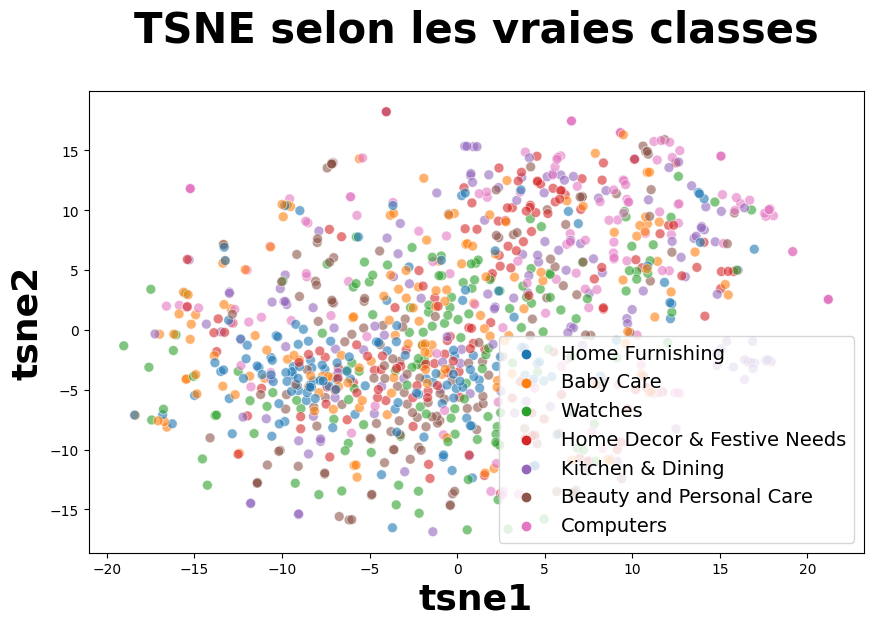

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

On constate qu'il est ici difficile de discerner des regroupements de catégories. Celles-ci sont toutes mélangées


In [17]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [18]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data["categ_1"])
data["label"] = le.transform(data["categ_1"])

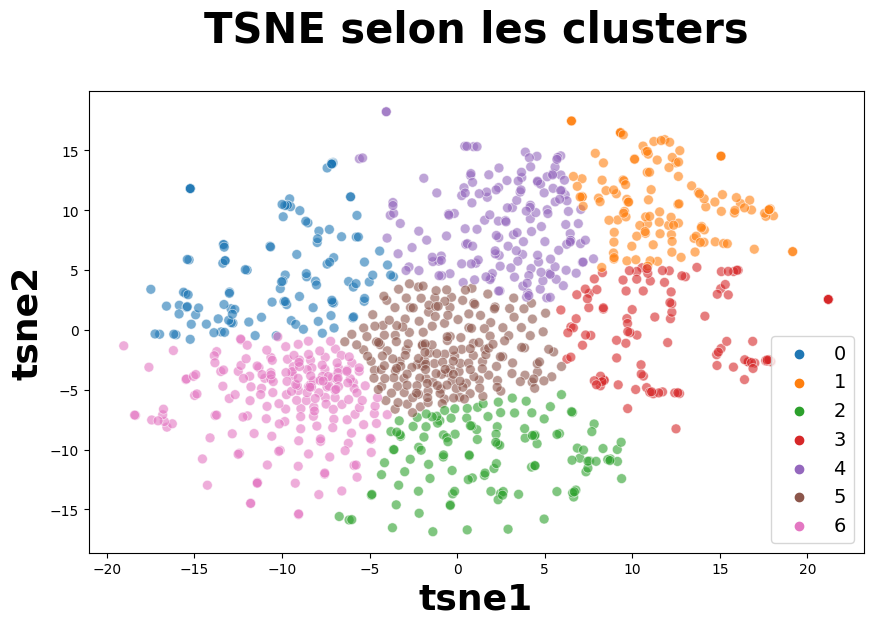

ARI :  0.04139035337136521


In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### ACP

In [20]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", img_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(img_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1436)
Dimensions dataset après réduction PCA :  (1050, 679)


In [21]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["categ_1"]
print(df_tsne.shape)

(1050, 3)


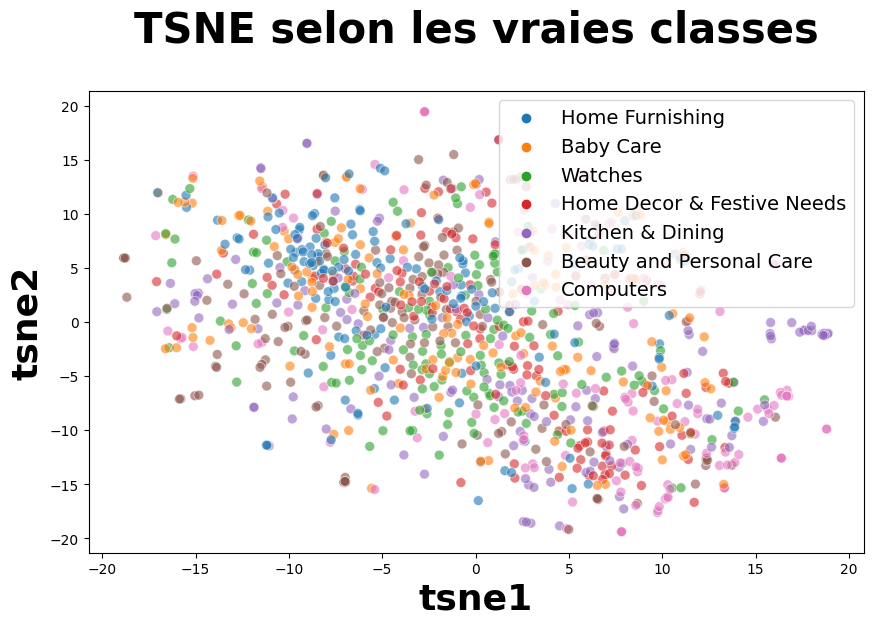

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

In [23]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [24]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data["categ_1"])
data["label"] = le.transform(data["categ_1"])

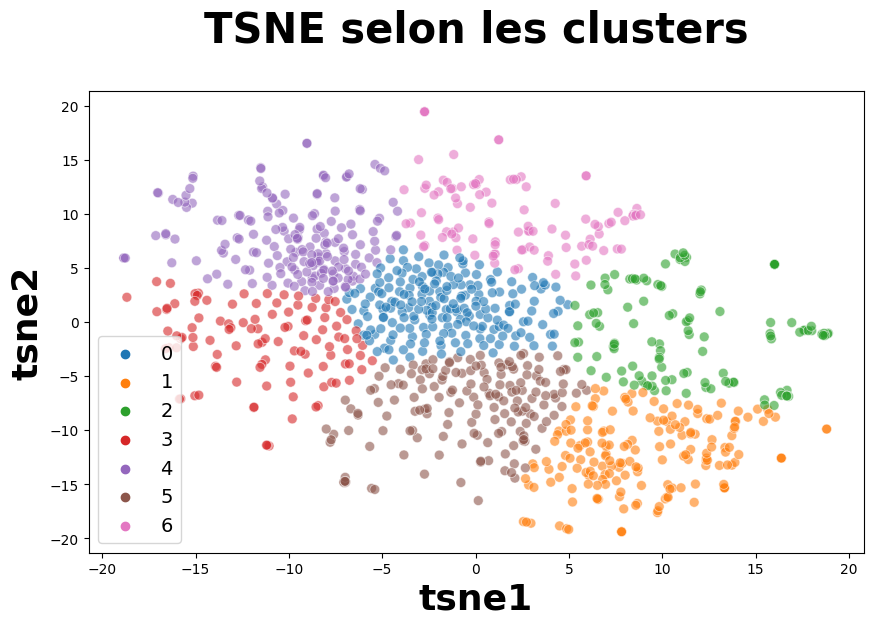

ARI :  0.04314527053011043


In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [26]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    197
1    176
2    120
3    108
4    181
5    165
6    103
Name: class, dtype: int64

In [27]:
df_tsne

tsne1      tsne2            class  cluster
0     -0.333171   0.545673  Home Furnishing        0
1     -7.526133   7.362879        Baby Care        4
2      3.904200   6.130594        Baby Care        6
3     -8.426478   6.003031  Home Furnishing        4
4    -10.048147   3.595962  Home Furnishing        4
...         ...        ...              ...      ...
1045 -16.017944  -2.386111        Baby Care        3
1046   8.545684   3.979913        Baby Care        2
1047   5.116435 -10.006754        Baby Care        1
1048  11.124224   6.389414        Baby Care        2
1049   0.723381   9.107807        Baby Care        6

[1050 rows x 4 columns]

In [28]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[24 15 16 15 38 28 14]
 [45 19  4 30 16 19 17]
 [ 7 55 31  9 11 17 20]
 [36 36 14  4 21 20 19]
 [33  7  8 10 62 17 13]
 [15 35 35 20 13 24  8]
 [37  9 12 20 20 40 12]]


In [29]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [3, 1, 2, 0, 4, 5, 6]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3, 1, 2, 0, 4, 5, 6]
[[15 15 16 24 38 28 14]
 [30 19  4 45 16 19 17]
 [ 9 55 31  7 11 17 20]
 [ 4 36 14 36 21 20 19]
 [10  7  8 33 62 17 13]
 [20 35 35 15 13 24  8]
 [20  9 12 37 20 40 12]]

              precision    recall  f1-score   support

           0       0.14      0.10      0.12       150
           1       0.11      0.13      0.12       150
           2       0.26      0.21      0.23       150
           3       0.18      0.24      0.21       150
           4       0.34      0.41      0.37       150
           5       0.15      0.16      0.15       150
           6       0.12      0.08      0.09       150

    accuracy                           0.19      1050
   macro avg       0.18      0.19      0.18      1050
weighted avg       0.18      0.19      0.18      1050



In [30]:
list_labels = data['categ_1'].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

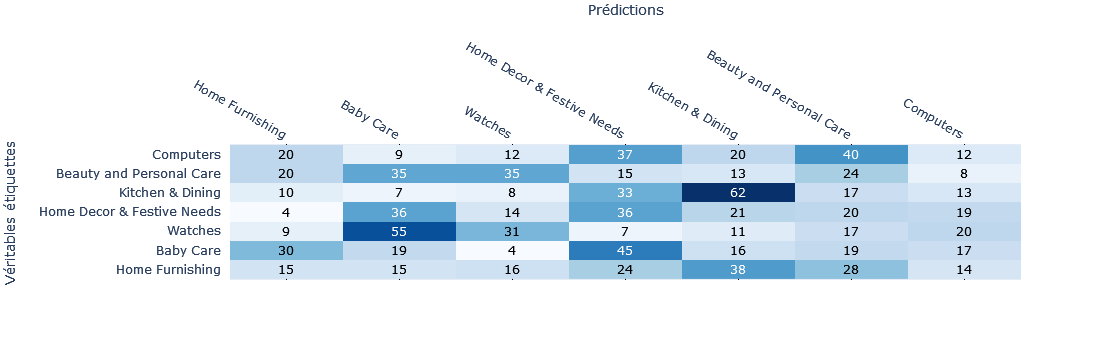

In [46]:
df = np.array(conf_mat) 
labels = list_labels
fig = ff.create_annotated_heatmap(df, x=labels, y=labels, colorscale='Blues')
fig.update_layout( xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()

La matrice de confusion ne donne pas de clustering évident. C'est cohérent puisque les scores sont faibles pour ce modèle.

# Extraction des features par CNN

## VGG16

In [47]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [48]:
len(list_photos)

1050

In [52]:
len(data['image'])

1050


    -VGG-16 reçoit des images de taille (224, 224, 3) : la fonction load_img permet de charger l'image et de la redimensionner correctement.
    -Keras traite les images comme des tableaux numpy : img_to_array permet de convertir l'image chargée en tableau numpy.
    -Le réseau doit recevoir en entrée une collection d'images, stockée dans un tableau de 4 dimensions, où les dimensions correspondent (dans l'ordre) à (nombre d'images, largeur, hauteur, profondeur). Pour l'instant, nous donnons qu'une image en entrée : numpy.reshape permet d'ajouter la première dimension (nombre d'images = 1) à notre image.
    -Enfin, preprocess_input permet d'appliquer les mêmes pré-traitements que ceux utilisés sur l'ensemble d'apprentissage lors du pré-entraînement

In [57]:
def extract_features_img(df, path, model):

    images_features = []

    for image_num in range(len(df['image'])) :
        image = load_img(path + df['image'][image_num], target_size=(224, 224))
        image = img_to_array(image) 
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        images_features.append(model.predict(image, verbose = 0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    print(images_features.shape)
    return images_features

In [61]:
images_features = extract_features_img(data, path_images, model)

(1050, 4096)


In [62]:
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(images_features)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["categ_1"]
print(df_tsne.shape)

(1050, 3)


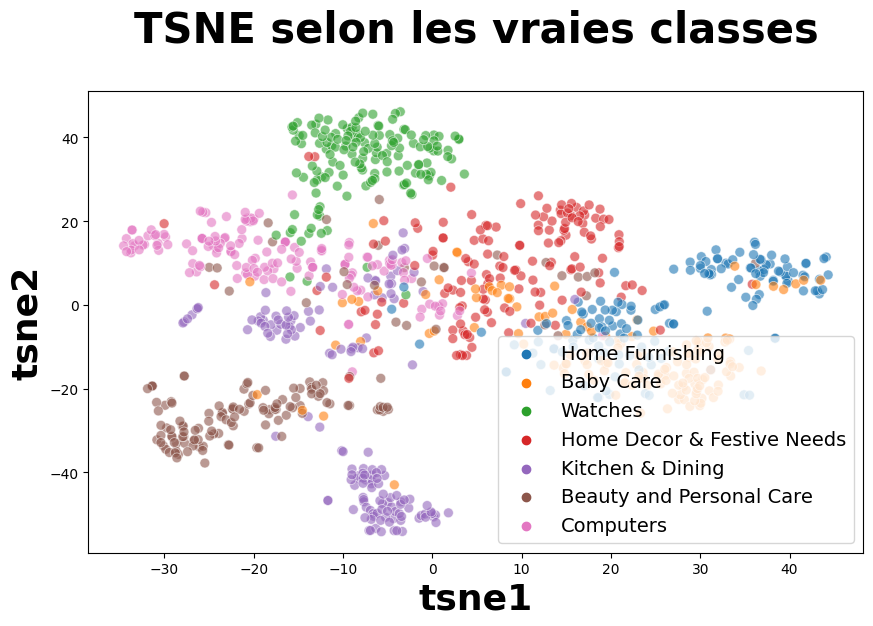

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

In [64]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


In [65]:
le = preprocessing.LabelEncoder()
le.fit(data["categ_1"])
data["label"] = le.transform(data["categ_1"])

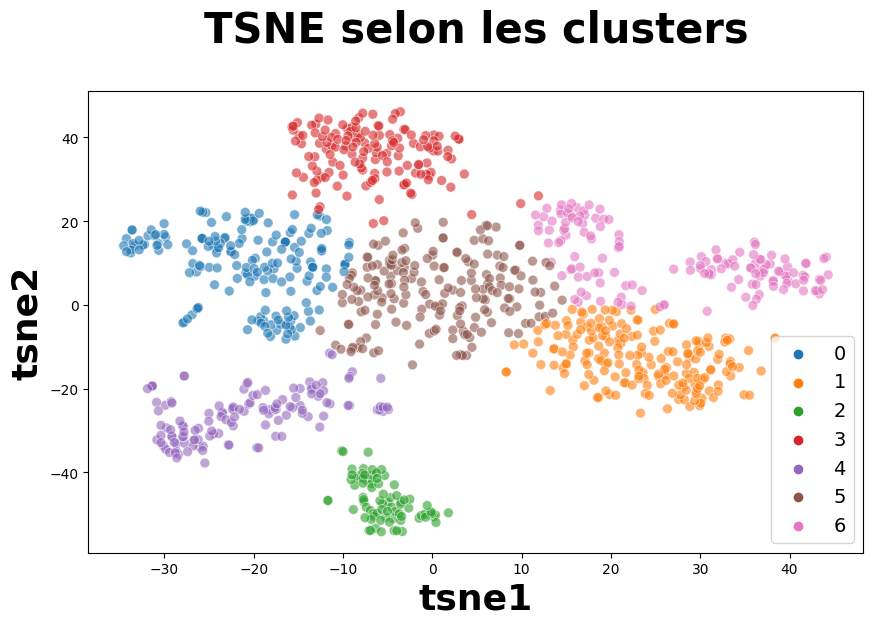

ARI :  0.4575067523826615


In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle.

### ACP

In [130]:
pca = PCA()
pca.fit(images_features)

PCA()

In [67]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = PCA(n_components=0.99)
feat_pca_vgg = pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


In [68]:
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca_vgg)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["categ_1"]
print(df_tsne.shape)

(1050, 3)


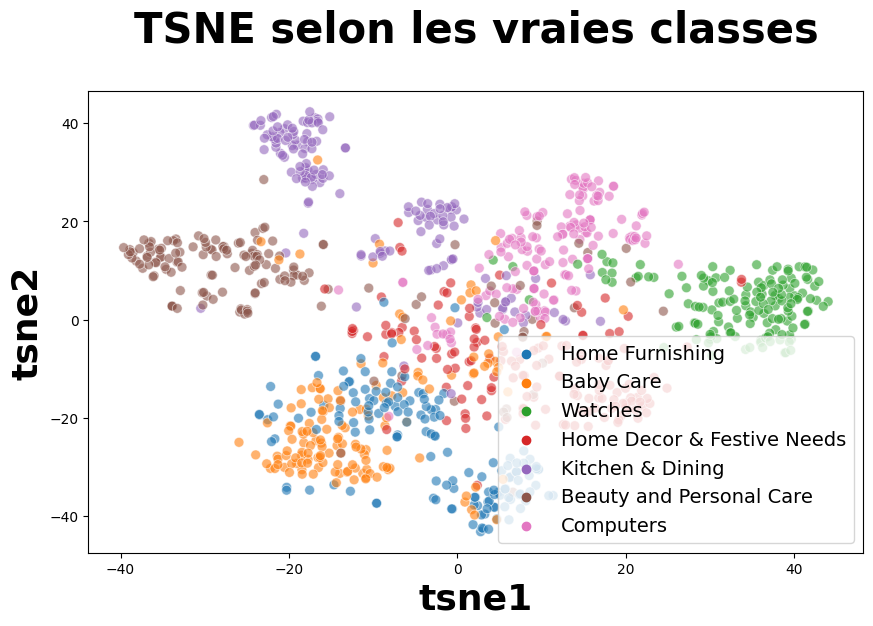

In [69]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes',
          fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

In [70]:

cls = cluster.KMeans(n_clusters=7, random_state=42, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


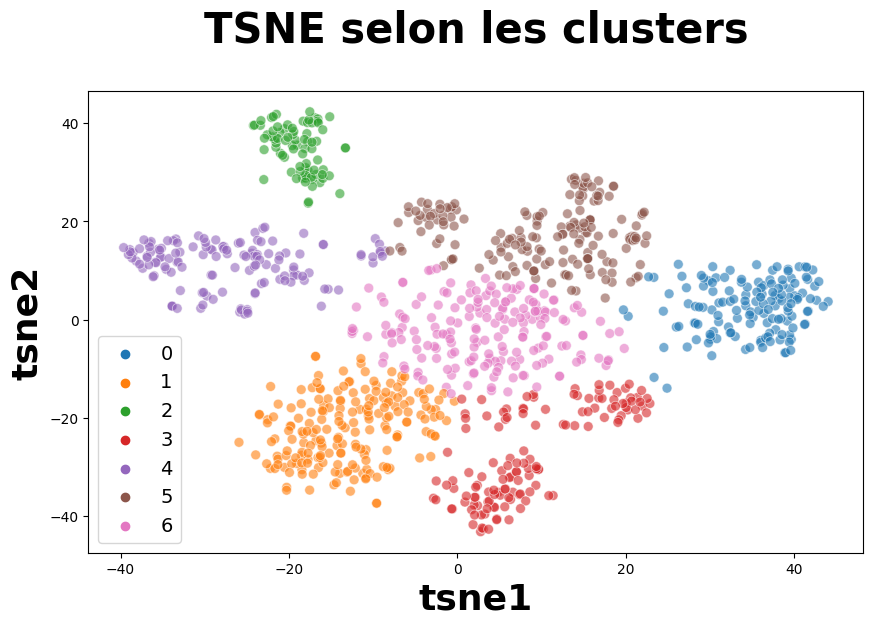

ARI :  0.447963346174419


In [71]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Analyse par classes

In [72]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1 109   1   7   5   1  26]
 [  1   5   1   5 117   7  14]
 [  1   1   0   0   1 107  40]
 [  6   3   0  56   1   6  78]
 [  0  79   0  67   0   0   4]
 [  0   0  78   0  11  37  24]
 [135   0   0   0   0  13   2]]


In [73]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [74]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 0 5 4 1 2 3]
[[109   5   1  26   7   1   1]
 [  5 117   7  14   5   1   1]
 [  1   1 107  40   0   0   1]
 [  3   1   6  78  56   0   6]
 [ 79   0   0   4  67   0   0]
 [  0  11  37  24   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.55      0.73      0.63       150
           1       0.87      0.78      0.82       150
           2       0.63      0.71      0.67       150
           3       0.41      0.52      0.46       150
           4       0.50      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.94      0.90      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.66      1050
weighted avg       0.70      0.66      0.66      1050



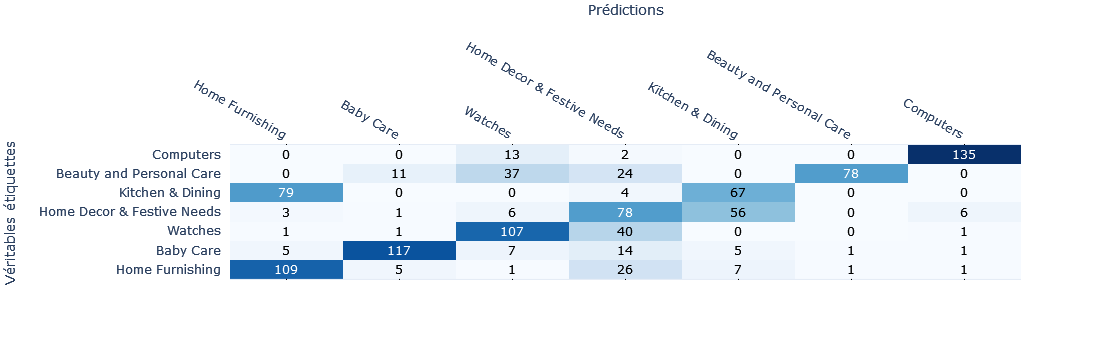

In [75]:
data = np.array(conf_mat) 
labels = list_labels
fig = ff.create_annotated_heatmap(data, x=labels, y=labels, colorscale='Blues')
fig.update_layout( xaxis=dict(title='Prédictions'), yaxis=dict(title='Véritables étiquettes'))
fig.show()